In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sqlite3
import shap
from dl_model import SimpleClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 데이터 불러오기
~~~
테이블 이름 : DVC0003, DVC0004, DVC0005
~~~

> * #### 1. 데이터 불러오기
> * #### 2. 데이터 확인
>   * ##### a. DVC 별 .info() 확인
>   * ##### b. 정상/비정상 별 데이터 개수 확인
> * #### 3. 데이터 전처리
>   * ##### a. 문자열 칼럼 삭제
>   * ##### b. 학습 데이터 셋 생성

#### 데이터 불러오기 - 1. 데이터 불러오기

In [2]:
# 1. 데이터 불러오기

conn = sqlite3.connect("../data/Database.db")
cursor = conn.cursor()

query_003 = "SELECT * FROM DVC0003"
query_004 = "SELECT * FROM DVC0004"
query_005 = "SELECT * FROM DVC0005"

df_0003 = pd.read_sql_query(query_003, conn)
df_0004 = pd.read_sql_query(query_004, conn)
df_0005 = pd.read_sql_query(query_005, conn)

# 추후 데이터 가공시 편하게 하기 위해 리스트에 변수들 담음
list_df = [df_0003, df_0004, df_0005]

#### 데이터 불러오기 - 2. 데이터 확인

In [3]:
# 2 .데이터 확인
#   a. .info() 데이터 확인

for df in list_df:
    vnames = [name for name in globals() if globals()[name] is df][0]

    print(vnames)
    print(df.info())
    print('==========================================================')

df_0003
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833349 entries, 0 to 833348
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   MODELNO               833349 non-null  object 
 1   DEVICECODE            833349 non-null  object 
 2   MP_PRDTIME            833349 non-null  object 
 3   STATUS_MS             833349 non-null  int64  
 4   MP_MINUTE             833349 non-null  object 
 5   System Pressure       833349 non-null  float64
 6   Discharge Pressure    833349 non-null  float64
 7   Stage 3 Inlet Temp    833349 non-null  float64
 8   Stage 1 Vibration     833349 non-null  float64
 9   Stage 2 Vibration     833349 non-null  float64
 10  Stage 3 Vibration     833349 non-null  float64
 11  Oil Pressure          833349 non-null  float64
 12  Oil Temperature       833349 non-null  float64
 13  Drive Motor Current   833349 non-null  float64
 14  Surge Count           833349 non-null  float

In [4]:
# 2 .데이터 확인
#   b. 정상/비정상 별 데이터 개수 확인

for df in list_df:
    # 변수이름 추출
    vnames = [name for name in globals() if globals()[name] is df]

    print("df 이름 : {}".format(vnames[0]))
    print("---------------------")
    print("전체 데이터 개수 : {}".format(len(df)))
    print("정상 데이터 갯수: ", len(df[df.STATUS_MS==1]))
    print("비정상 데이터 갯수: ", len(df[df.STATUS_MS==2]))
    print("\n")


df 이름 : df_0003
---------------------
전체 데이터 개수 : 833349
정상 데이터 갯수:  832307
비정상 데이터 갯수:  1042


df 이름 : df_0004
---------------------
전체 데이터 개수 : 833284
정상 데이터 갯수:  833263
비정상 데이터 갯수:  21


df 이름 : df_0005
---------------------
전체 데이터 개수 : 833336
정상 데이터 갯수:  833327
비정상 데이터 갯수:  9




#### 데이터 불러오기 - 3. 데이터 전처리

In [6]:
# 3. 데이터 전처리
#   a. 문자열 칼럼 삭제
import copy

del_column_list = ["MODELNO", "DEVICECODE", "MP_PRDTIME", "MP_MINUTE"]

# 동적 변수로 전처리 df 생성
# pp_df_0003, pp_df_0004, pp_df_0005
for df in list_df: 
    vnames = [name for name in globals() if globals()[name] is df]
    drop_df = df.drop(del_column_list, axis = "columns")
    drop_df["STATUS_MS"] = drop_df["STATUS_MS"].replace({1 : 0, 2 : 1})

    globals()["pp_{}".format(vnames[0])] = copy.deepcopy(drop_df)

# 전처리 된 데이터 리스트에 담아서 관리
pp_df_list = [pp_df_0003, pp_df_0004, pp_df_0005]    

## SHAP 모델 생성
~~~
모델 종류 : pytorch
~~~

> * ### 1. 테스트 모델 생성
>   > SHAP 모델에 전달하기 위한 TEST 모델 생성
>   * ##### a. 모델 학습을 위한 데이터 셋 생성 & 학습 진행
> * ### 2. Shap 모델 생성 및 Shap value 그래프 확인

#### SHAP 모델 생성 - 1. 테스트 모델 생성

In [14]:
# 학습 자동화 함수 생성

def train_model(num_epochs, model, criterion, optimizer, X, Y):
    for epoch in range(num_epochs):
        inputs = torch.tensor(X.values, dtype=torch.float32)
        labels = torch.tensor(Y.values, dtype=torch.float32).view(-1, 1)

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        # 역전파 및 옵티마이저 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # 로그 출력
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [24]:
import copy

# 모델 초기화
hidden_size = 1
output_size = 1

for train_df in pp_df_list:
    vnames = [name for name in globals() if globals()[name] is train_df][0]
    dvc_number = vnames.split("_")[-1]
    
    x_train = train_df.drop(["STATUS_MS"], axis = "columns")
    y_train = train_df["STATUS_MS"]
    input_size = x_train.shape[1]

    # 따로 전역변수 저장이유 : Shap 모델 생성시, 판별 X 데이터가 필요함
    globals()["x_train_{}".format(dvc_number)] = torch.tensor(x_train.values, dtype=torch.float32)
    globals()["y_train_{}".format(dvc_number)] = torch.tensor(y_train.values, dtype=torch.float32)

    # 동적으로 dvc_number 별로 model, criterion, optimizer 변수 할당
    globals()["model_{}".format(dvc_number)] = SimpleClassifier(input_size, hidden_size, output_size)
    globals()["criterion_{}".format(dvc_number)] = nn.BCELoss()  # Binary Cross Entropy Loss
    globals()["optimizer_{}".format(dvc_number)] = optim.Adam(globals()["model_{}".format(dvc_number)].parameters(), lr=0.001)

    # 동적으로 생성된 모델 학습 실행
    train_model(
        num_epochs = 20, 
        model = globals()["model_{}".format(dvc_number)], 
        criterion = globals()["criterion_{}".format(dvc_number)],
        optimizer = globals()["optimizer_{}".format(dvc_number)], 
        X = x_train, Y = y_train
    )

#### SHAP 모델 생성 - 2. Shap 모델 생성 및 Shap value 그래프 확인

In [26]:
# pytorch 사용한 Neural Network 모델의 shap value 구하기

explainer_0003 = shap.DeepExplainer(model_0003, x_train_0003)
shap_value_0003 = explainer_0003.shap_values(x_train_0003)

explainer_0004 = shap.DeepExplainer(model_0004, x_train_0004)
shap_value_0004 = explainer_0003.shap_values(x_train_0004)

explainer_0005 = shap.DeepExplainer(model_0005, x_train_0005)
shap_value_0005 = explainer_0005.shap_values(x_train_0005)

# 근데 너무 오래 걸림. 이게 맞는지 모르겠음

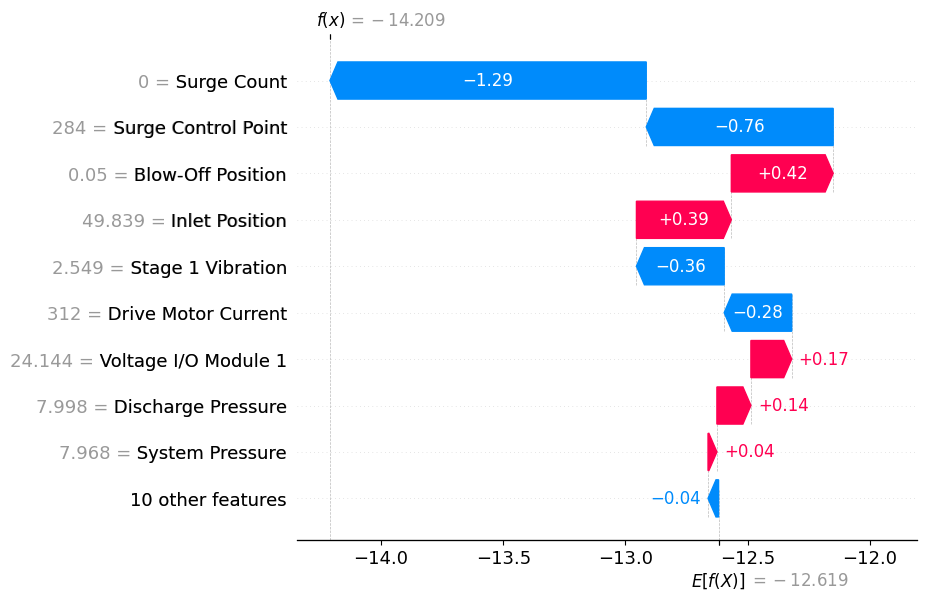

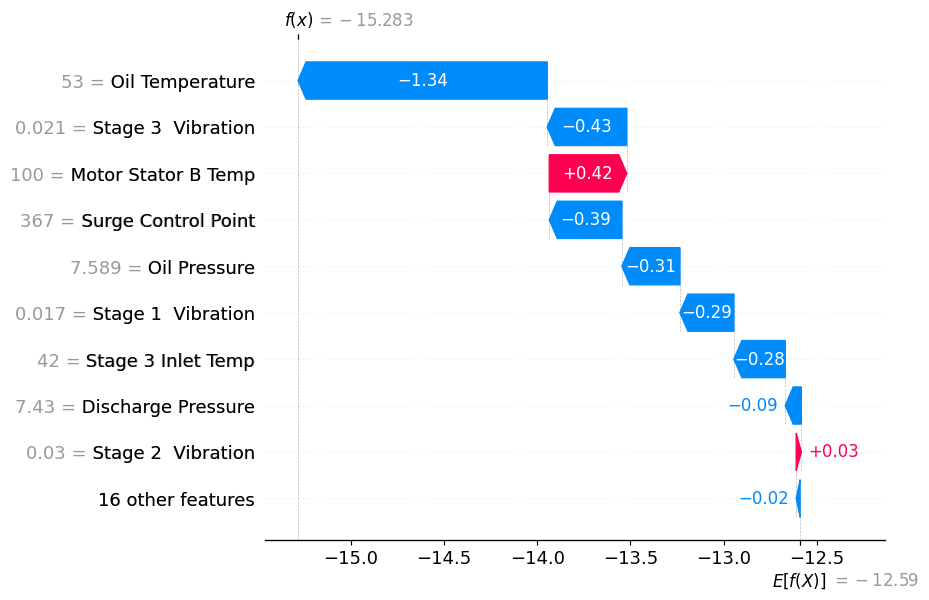

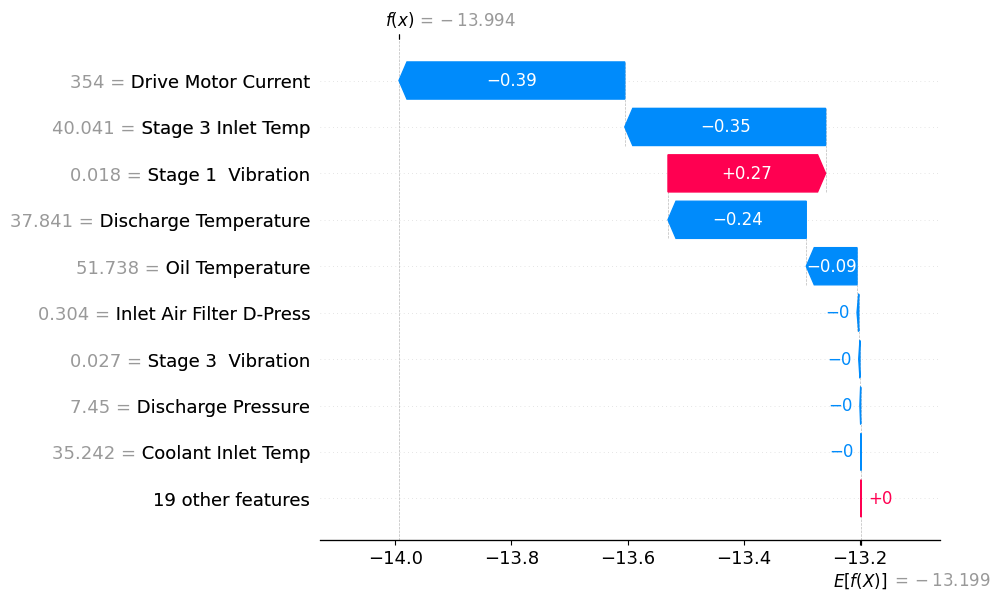

In [26]:
# shap value 로 그래프 그리기

shap_xgb_list = [shap_value_0003, shap_value_0003, shap_value_0003]

for shap_value in shap_xgb_list:
    shap.plots.waterfall(shap_value[0])

## Column 별 shap value 추출 함수 구현
~~~
가능한 모델들 : XGBoost, CatBoost
~~~

In [17]:
def shap_model(model, X):
    # model : xgboost, catboost 등 학습이 완료된 모델
    # X : 모델 학습시 사용해던 데이터 [DataFrame]
    explainer = shap.Explainer(model)
    shap_value = explainer(X)[0].values
    column_names = X.columns

    result = {}
    for index, col in enumerate(column_names):
        result[col] = shap_value[index]
    
    return result